<a href="https://colab.research.google.com/github/sujeet311/qsvm/blob/main/salvation_qsvs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# External imports
from pylab import cm
import pandas as pd
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import circuit_drawer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data

In [ ]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

In [ ]:
pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 4.4 MB/s 
     |████████████████████████████████| 18.0 MB 198 kB/s 
     |████████████████████████████████| 240 kB 33.1 MB/s 
     |████████████████████████████████| 112 kB 47.2 MB/s 
     |████████████████████████████████| 54 kB 1.1 MB/s 
     |████████████████████████████████| 49 kB 3.2 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 65.0 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 943 kB 47.0 MB/s 
     |████████████████████████████████| 4.1 MB 33.1 MB/s 
     |████████████████████████████████| 112 kB 59.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.37.0-py3-none-any.whl size=12028 sha256=4b177e87f39caeb5ab7b089fa0e52e0d1c649fca3e7bdc026dea980983045c42
  Stored in directory: /root/.cache/pip/wheels/ed/f9/fa/3ed81

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install qiskit_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 5.1 MB/s 


In [ ]:
from qiskit import IBMQ

In [ ]:
pip install qiskit-ibmq-provider

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
IBMQ.save_account('3e4aade17521ec826605c890d09ce72429f10032c57d8b62fb4331f7a19e3e079b8e682246e31be652f81a4f69aa2db520ef01af3f9a4bec168fda792000cb15',overwrite=True)
provider = IBMQ.load_account()

In [ ]:
from numpy import loadtxt
X_train = loadtxt('/content/drive/MyDrive/code thesis/train_test/X_train.csv',delimiter=',')
y_train = loadtxt('/content/drive/MyDrive/code thesis/train_test/y_train.csv',delimiter=',')
X_test = loadtxt('/content/drive/MyDrive/code thesis/train_test/X_test.csv',delimiter=',')
y_test = loadtxt('/content/drive/MyDrive/code thesis/train_test/y_test.csv',delimiter=',')

In [ ]:
# I scale the data to fit it to a normal distribution
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA

n_dim = 2
# I use PCA to reduce the number of dimensions of the dataset down to n_dim = 2
pca = PCA(n_components=n_dim).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)


In [ ]:
 # I scale the data between -1 and 1
from sklearn.preprocessing import  MinMaxScaler

samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)


In [ ]:
class_labels = ['Non-Dibetic', 'Dibetic']


In [ ]:
print(len(X_train),len(X_test))

def select_training_test_size(training_size=None, test_size=None):

    if not training_size==None:
        # I restrict the training data and test data
        training_input = {key: (X_train[y_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (X_test[y_test == k, :])[:test_size]
                      for k, key in enumerate(class_labels)}

    else:
        # I keep the whole dataset
        training_input = {key: (X_train[y_train == k, :])
                          for k, key in enumerate(class_labels)}
        test_input = {key: (X_test[y_test == k, :])
                      for k, key in enumerate(class_labels)}
    return training_input, test_input

training_input, test_input = select_training_test_size()
count, count2 = 0, 0
for l in training_input.values():
    count+=len(l)
for l in test_input.values():
    count2+=len(l)
print(count, count2, count+count2)

272127 116627
272127 116627 388754


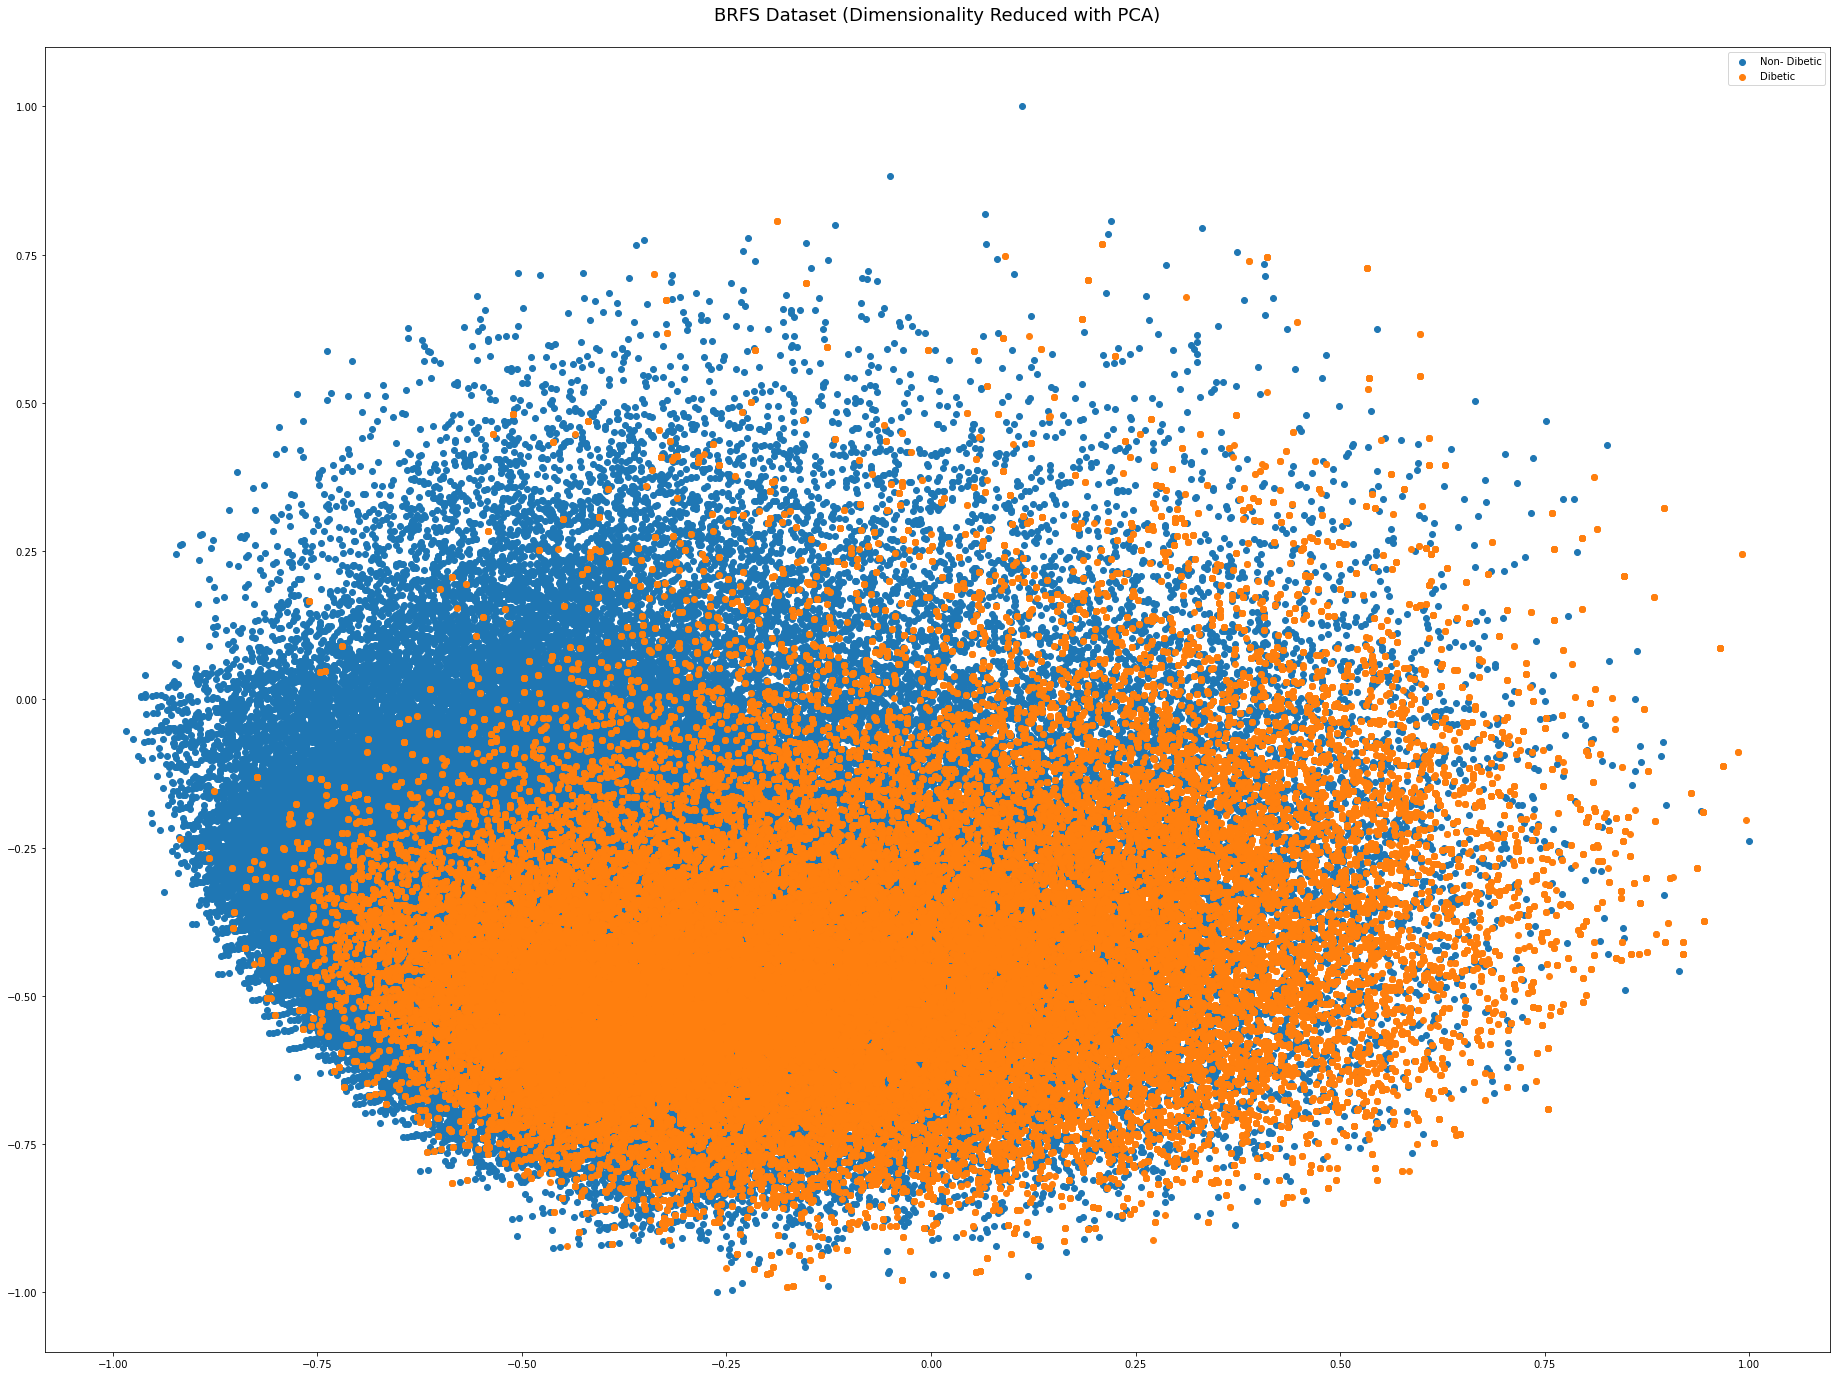

In [ ]:
# I plot the 2D representation of the data, reduced in dimensionality using PCA
plt.figure(figsize=(32, 24))
for k in range(0, 2):
    x_axis_data = X_train[y_train == k, 0][:len(X_train)]
    y_axis_data = X_train[y_train == k, 1][:len(X_train)]
    if k is 1:
        label = 'Dibetic'
    else:
        label = 'Non- Dibetic'
    plt.scatter(x_axis_data, y_axis_data, label=label)
plt.title("BRFS Dataset (Dimensionality Reduced with PCA)\n",
          fontdict = {'fontsize': 18})
plt.legend()
plt.savefig("plot2.png")
plt.show()

In [ ]:
# Create a rotational layer to train. We will rotate each qubit the same amount.
user_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(2)
fm0.ry(user_params[0], 0)
fm0.ry(user_params[0], 1)

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(2)

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {user_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


In [ ]:
# Use the qasm simulator backend
backend = AerSimulator(method="statevector")

# Instantiate quantum kernel
quant_kernel = QuantumKernel(fm, user_parameters=user_params, quantum_instance=backend)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

In [ ]:
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

In [ ]:
from joblib import Parallel, delayed
import joblib
# Save the model as a pickle in a file
joblib.dump(pegasos_qsvc, '/content/drive/MyDrive/code thesis/ml_model/pqsvc.pkl')